<a href="https://colab.research.google.com/github/MHamiid/Sign_Language_Classifier/blob/master/Sign_Language_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import csv
import json
import zipfile
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Set Kaggle.json 

In [0]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json #json file needed to use kaggle api.

api_token = {"username":"UserName","key":"ApiKey"} #use your own kaggle username and api key.

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

Download sign language dataset

In [3]:
!kaggle datasets download -d datamunge/sign-language-mnist

 81% 51.0M/62.6M [00:03<00:01, 8.73MB/s]
100% 62.6M/62.6M [00:03<00:00, 17.6MB/s]


In [0]:
#Unzip data set
!mkdir /content/dataset
dataset_zip = '/content/sign-language-mnist.zip'
zip_ref = zipfile.ZipFile(dataset_zip, 'r')
zip_ref.extractall('/content/dataset')
zip_ref.close()


In [0]:
def get_csv_data(filename):
    with open(filename) as training_file:
        csv_reader = csv.reader(training_file, delimiter=',') 
        first_line = True
        images = []
        labels = []
        for row in csv_reader:
            if first_line:
                first_line = False
            else:
                labels.append(row[0])
                image_data =np.array_split(row[1:] , 28)
                images.append(image_data)
        images = np.array(images).astype('float')
        labels = np.array(labels).astype('float')
    return images, labels



In [6]:
path_sign_mnist_train = "/content/dataset/sign_mnist_train/sign_mnist_train.csv"
path_sign_mnist_test = "/content/dataset/sign_mnist_test/sign_mnist_test.csv"
training_images, training_labels = get_csv_data(path_sign_mnist_train)
testing_images, testing_labels = get_csv_data(path_sign_mnist_test)

print("Training data shape: ", training_images.shape)
print("Testing data shape: ",testing_images.shape)


Training data shape:  (27455, 28, 28)
Testing data shape:  (7172, 28, 28)


In [0]:
#expand one more dimension for the image channel.
training_images = np.expand_dims(training_images , axis = 3)
testing_images = np.expand_dims(testing_images , axis = 3)

Create an *ImageDataGenerator* and do *Image Augmentation*


In [0]:
train_datagen_intilize = ImageDataGenerator(
     rescale=1. / 255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')
validation_datagen_intilize = ImageDataGenerator(
    rescale = 1./255.)


train_generator = train_datagen_intilize.flow(training_images ,training_labels, batch_size = 32)
test_generator = validation_datagen_intilize.flow(testing_images, testing_labels, batch_size = 32)

# Define the model

In [0]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation="relu"),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(26, activation="softmax")]
    )

In [0]:
#Compile model
model.compile(optimizer = tf.optimizers.Adam(),
              loss = 'sparse_categorical_crossentropy',
              metrics=['acc'])

In [0]:
# Define a Callback class that stops training once accuracy reaches 92.0%
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc')>0.92):
      print("\nReached 92% accuracy so cancelling training!")
      self.model.stop_training = True
callback = myCallback()      

In [18]:
#Training the model
history = model.fit(train_generator , validation_data = test_generator ,
                              steps_per_epoch=len(training_images) / 32
                              ,validation_steps=len(testing_images) / 32
                              ,epochs = 100 , callbacks = [callback])


Epoch 1/100
858/857 [==============================] - 16s 19ms/step - loss: 2.7854 - acc: 0.1381 - val_loss: 2.1330 - val_acc: 0.2676
Epoch 2/100
858/857 [==============================] - 16s 19ms/step - loss: 1.7975 - acc: 0.4080 - val_loss: 1.1062 - val_acc: 0.5943
Epoch 3/100
858/857 [==============================] - 16s 19ms/step - loss: 1.3459 - acc: 0.5462 - val_loss: 0.8228 - val_acc: 0.7083
Epoch 4/100
858/857 [==============================] - 16s 19ms/step - loss: 1.0871 - acc: 0.6314 - val_loss: 0.6147 - val_acc: 0.7695
Epoch 5/100
858/857 [==============================] - 16s 19ms/step - loss: 0.9287 - acc: 0.6836 - val_loss: 0.4603 - val_acc: 0.8194
Epoch 6/100
858/857 [==============================] - 16s 19ms/step - loss: 0.8281 - acc: 0.7162 - val_loss: 0.4293 - val_acc: 0.8540
Epoch 7/100
858/857 [==============================] - 16s 19ms/step - loss: 0.7260 - acc: 0.7511 - val_loss: 0.3260 - val_acc: 0.8865
Epoch 8/100
858/857 [==============================] - 

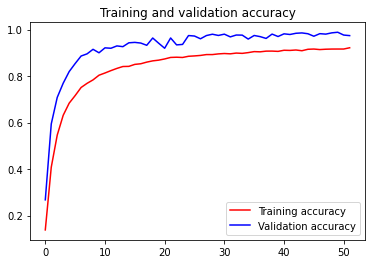

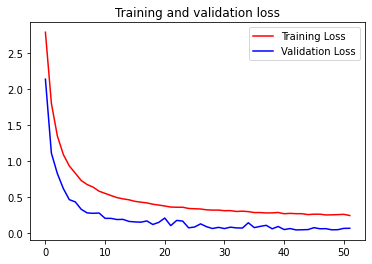

In [19]:
# Plot the chart for accuracy and loss on both training and validation
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [0]:
model.save("Sign_language_model.h5")